In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
!pip install geopandas
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

import sklearn
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [129]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [130]:
base = pd.read_csv('/content/drive/MyDrive/Mini-proyecto Texto/tweets_mnm.csv')
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1206924075374956547,Las feminazis quieren por poco que este chico ...,2019-12-17 13:08:17,Argentina,1683,2710,28982,El Progresismo es un Cáncer que quiere destrui...,False,es,misogino
1,1210912199402819584,@CarlosVerareal @Galois2807 Los halagos con pi...,2019-12-28 13:15:40,Ecuador,398,1668,3123,Cuando te encuentres n una situación imposible...,False,es,misogino
2,1210643148998938625,@drummniatico No se vaya asustar! Ese es el gr...,2019-12-27 19:26:34,Samborondon - Ecuador,1901,1432,39507,Todo se alinea a nuestro favor. 💙💙💙💙,False,es,misogino
3,1210643148998938625,@drummniatico No se vaya asustar! Ese es el gr...,2019-12-27 19:26:34,Samborondon - Ecuador,1901,1432,39507,Todo se alinea a nuestro favor. 💙💙💙💙,False,es,misogino


In [131]:
base.dtypes

ID                      int64
Tweet                  object
Creado_tweet           object
Locacion_usuario       object
Seguidores_usuario      int64
Amigos_usuario          int64
Favoritos_usuario       int64
Descripcion_usuario    object
Verificado_usuario       bool
Idioma                 object
Tipo                   object
dtype: object

In [132]:
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       5375
no_misogino    4869
Name: Tipo, dtype: int64

In [133]:
base = base.drop_duplicates(base.columns[~base.columns.isin(['ID'])],
                                keep = 'first')
base = base.reset_index(drop=True)
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1206924075374956547,Las feminazis quieren por poco que este chico ...,2019-12-17 13:08:17,Argentina,1683,2710,28982,El Progresismo es un Cáncer que quiere destrui...,False,es,misogino
1,1210912199402819584,@CarlosVerareal @Galois2807 Los halagos con pi...,2019-12-28 13:15:40,Ecuador,398,1668,3123,Cuando te encuentres n una situación imposible...,False,es,misogino
2,1210643148998938625,@drummniatico No se vaya asustar! Ese es el gr...,2019-12-27 19:26:34,Samborondon - Ecuador,1901,1432,39507,Todo se alinea a nuestro favor. 💙💙💙💙,False,es,misogino
3,1203627609759920128,Mostritas #Feminazi amenazando como ellas sabe...,2019-12-08 10:49:19,"Lima, Perú",2504,3824,45087,Latam News Report. Regional and World affairs....,False,es,misogino


In [134]:
base = base[(base.Idioma == "es")]
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       3661
no_misogino    3757
Name: Tipo, dtype: int64

In [135]:
base = sklearn.utils.shuffle(base)
base = base.reset_index(drop=True)
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1221935001358553094,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,2020-01-27 23:16:21,NaN,125,272,2356,NaN,False,es,no_misogino
1,1204474536105775104,Bolsonaro llama “mocosa” a Greta Thunberg http...,2019-12-10 18:54:42,La Paz,9217,963,3417,Periodista. Bolivia. Con las bendiciones de la...,False,es,no_misogino
2,1220773906186936321,@DeyaCabrera92 @MousemallowTV @DalasReview A m...,2020-01-24 18:22:34,CDMX,34,649,1625,Te quiero mucho.,False,es,misogino
3,1203620983392931841,Imaginen pasar 10 horas mentida en una cocina ...,2019-12-08 10:22:59,Culiacán,809,871,105497,𝑺𝒐𝒚 𝒕𝒐𝒅𝒂𝒔 𝒍𝒂𝒔 𝒇𝒍𝒐𝒓𝒆𝒔 𝒄𝒖𝒂𝒏𝒅𝒐 𝒚𝒂 𝒆𝒔𝒕𝒂́𝒏 𝒎𝒖𝒆𝒓𝒕𝒂𝒔.,False,es,no_misogino


# Limpieza de texto

In [136]:
TText = pd.DataFrame({'Texto': base['Tweet'], 'Tipo': base['Tipo']})
TText.head(3)

,Texto,Tipo
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino
2,@DeyaCabrera92 @MousemallowTV @DalasReview A m...,misogino


In [137]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(TText.shape))
print('\n')
print(TText.columns)

Dimensiones: (7418, 2)


Index(['Texto', 'Tipo'], dtype='object')


In [138]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de usuarios
    nuevo_texto = re.sub('@[\w\-]+', ' ', nuevo_texto)

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', ' ', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [139]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['Texto_Limpio'] = TText['Texto'].apply(lambda x: Limpiar_texto(x))
TText[['Texto', 'Tipo', 'Texto_Limpio']].head(3)

,Texto,Tipo,Texto_Limpio
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,qué farmacéutica a nivel mundial y amiguis de...
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa a greta thunberg vía
2,@DeyaCabrera92 @MousemallowTV @DalasReview A m...,misogino,a mi ni siquiera me cae bien dalas ustedes so...


In [140]:
# Stopwords en ingles
sw = stopwords.words('spanish')

# Nuevas stopwords
#nuevas_sw = ('one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'amp',
#             'rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's')

#for i in nuevas_sw:
#    sw.append(i)

#print(sw)

In [141]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['Texto_Pos'] = TText['Texto_Limpio'].apply(token_stop_pos)
TText.head(5)

,Texto,Tipo,Texto_Limpio,Texto_Pos
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,qué farmacéutica a nivel mundial y amiguis de...,"[(farmacéutica, v), (nivel, a), (mundial, a), ..."
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa a greta thunberg vía,"[(bolsonaro, n), (llama, n), (mocosa, v), (gre..."
2,@DeyaCabrera92 @MousemallowTV @DalasReview A m...,misogino,a mi ni siquiera me cae bien dalas ustedes so...,"[(siquiera, n), (cae, a), (bien, a), (dalas, n..."
3,Imaginen pasar 10 horas mentida en una cocina ...,no_misogino,imaginen pasar horas mentida en una cocina con...,"[(imaginen, n), (pasar, n), (horas, n), (menti..."
4,-Noticias: Fracaso en el COP25 \n- Greta:????\...,no_misogino,noticias fracaso en el cop greta some people ...,"[(noticias, a), (fracaso, n), (cop, n), (greta..."


In [142]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['Lema'] = TText['Texto_Pos'].apply(lemmatize)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,qué farmacéutica a nivel mundial y amiguis de...,"[(farmacéutica, v), (nivel, a), (mundial, a), ...",farmacéutica nivel mundial amiguis mandatari...
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa a greta thunberg vía,"[(bolsonaro, n), (llama, n), (mocosa, v), (gre...",bolsonaro llama mocosa greta thunberg vía


In [143]:
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['Mayores'] = TText['Lema'].apply(mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,qué farmacéutica a nivel mundial y amiguis de...,"[(farmacéutica, v), (nivel, a), (mundial, a), ...",farmacéutica nivel mundial amiguis mandatari...,"[farmacéutica, nivel, mundial, amiguis, mandat..."
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa a greta thunberg vía,"[(bolsonaro, n), (llama, n), (mocosa, v), (gre...",bolsonaro llama mocosa greta thunberg vía,"[bolsonaro, llama, mocosa, greta, thunberg, vía]"


In [144]:
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['Lema_Mayores'] = TText['Mayores'].apply(lema_mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,qué farmacéutica a nivel mundial y amiguis de...,"[(farmacéutica, v), (nivel, a), (mundial, a), ...",farmacéutica nivel mundial amiguis mandatari...,"[farmacéutica, nivel, mundial, amiguis, mandat...",farmacéutica nivel mundial amiguis mandatari...
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa a greta thunberg vía,"[(bolsonaro, n), (llama, n), (mocosa, v), (gre...",bolsonaro llama mocosa greta thunberg vía,"[bolsonaro, llama, mocosa, greta, thunberg, vía]",bolsonaro llama mocosa greta thunberg vía


In [145]:
Texto_final = TText.loc[:, ['Texto', 'Tipo', 'Lema_Mayores']]
Texto_final.head(2)

,Texto,Tipo,Lema_Mayores
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,farmacéutica nivel mundial amiguis mandatari...
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa greta thunberg vía


In [146]:
Texto_final['Categoria_ID'] = Texto_final['Tipo'].factorize()[0]
Categoria_ID_datos = Texto_final[['Tipo', 'Categoria_ID']].drop_duplicates().sort_values('Categoria_ID')
Categoria_a_ID = dict(Categoria_ID_datos.values)
ID_a_Categoria = dict(Categoria_ID_datos[['Categoria_ID', 'Tipo']].values)
Texto_final.head(2)

,Texto,Tipo,Lema_Mayores,Categoria_ID
0,@AnabelAlonso_of @el_pais Qué farmacéutica a n...,no_misogino,farmacéutica nivel mundial amiguis mandatari...,0
1,Bolsonaro llama “mocosa” a Greta Thunberg http...,no_misogino,bolsonaro llama mocosa greta thunberg vía,0


In [147]:
Tabla_Conteo = Texto_final['Tipo'].value_counts()
Tabla_Conteo

no_misogino    3757
misogino       3661
Name: Tipo, dtype: int64

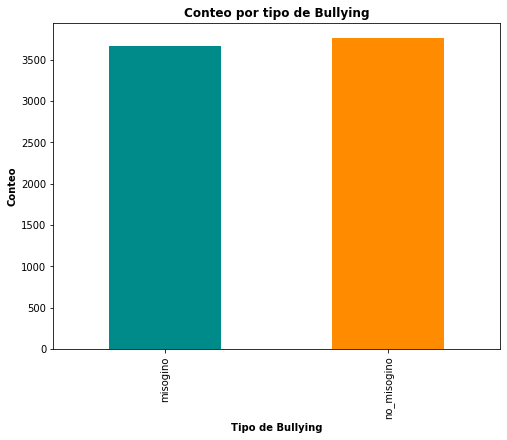

In [148]:
color = ['darkcyan', 'darkorange']
fig = plt.figure(figsize=(8,6))
Texto_final.groupby('Tipo').Lema_Mayores.count().plot.bar(ylim=0, color=color)
plt.title('Conteo por tipo de Bullying', fontweight = 'bold')
plt.xlabel('Tipo de Bullying', fontweight = 'bold')
plt.ylabel('Conteo', fontweight = 'bold')
plt.show()

# Modelo

In [149]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', encoding = 'latin-1',
                        ngram_range = (1, 2), stop_words = 'english')

features = tfidf.fit_transform(Texto_final.Lema_Mayores).toarray()
labels = Texto_final.Categoria_ID
features.shape

(7418, 3238)

In [159]:
N = 3
for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
  features_chi2 = chi2(features, labels == Categoria_ID)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Tipo))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'misogino':
  . Most correlated unigrams:
       . payasa
       . arandina
       . feminazis
  . Most correlated bigrams:
       . greta thunberg
       . cállate puta
       . callate puta
# 'no_misogino':
  . Most correlated unigrams:
       . payasa
       . arandina
       . feminazis
  . Most correlated bigrams:
       . greta thunberg
       . cállate puta
       . callate puta


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [151]:
X_train, X_test, y_train, y_test = train_test_split(Texto_final['Lema_Mayores'],
                                                    Texto_final['Tipo'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [152]:
models = [RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0)]

CV = 10
cv_df = pd.DataFrame(index = range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

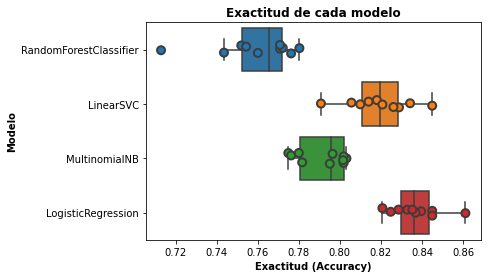

<Figure size 1440x3600 with 0 Axes>

In [153]:
sns.boxplot(x='accuracy', y='model_name', data=cv_df)
sns.stripplot(x='accuracy', y='model_name', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Exactitud de cada modelo', fontweight = 'bold')
plt.xlabel('Exactitud (Accuracy)', fontweight = 'bold')
plt.ylabel('Modelo', fontweight = 'bold')
plt.figure(figsize=(20, 50))
plt.show()

In [154]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.819353
LogisticRegression        0.837017
MultinomialNB             0.791318
RandomForestClassifier    0.759366
Name: accuracy, dtype: float64

In [155]:
model = LogisticRegression(random_state = 0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, Texto_final.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Reporte

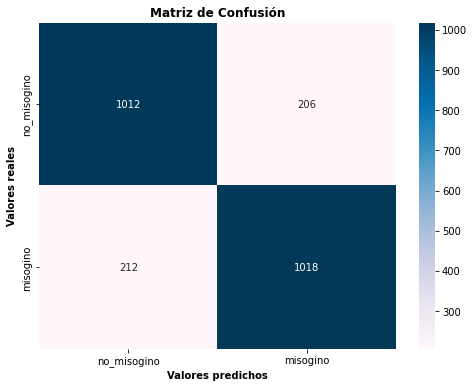

In [156]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Categoria_ID_datos.Tipo.values,
            yticklabels=Categoria_ID_datos.Tipo.values, cmap = 'PuBu',
            linecolor = 'black')
plt.title('Matriz de Confusión', fontweight = 'bold')
plt.xlabel('Valores predichos', fontweight = 'bold')
plt.ylabel('Valores reales', fontweight = 'bold')
plt.show()

In [157]:
for predicted in Categoria_ID_datos.Categoria_ID:
  for actual in Categoria_ID_datos.Categoria_ID:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(ID_a_Categoria[actual], ID_a_Categoria[predicted], conf_mat[actual, predicted]))
      display(Texto_final.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Tipo', 'Texto']])
      print('')

'misogino' predicted as 'no_misogino' : 212 examples.


,Tipo,Texto
4194,misogino,@DisidenciaD @jvacaredondo Tengo artritis reum...
1953,misogino,Cuando pasen 20 o 30 años tod@s los adolescent...
1590,misogino,Para estos carnavales amiga feminista o fémina...
4582,misogino,@InesArrimadas No en tens ni puta idea!
1741,misogino,"@DalasReview Así que pienso que es inocente,ya..."
...,...,...
6055,misogino,@todonoticias se lo pasan a la histérica de lo...
710,misogino,"Normal, gilipollas. Hasta que la verborrea de ..."
3403,misogino,@elespectador @GretaThunberg @RevistaCromos No...
64,misogino,@InesArrimadas Arrimadas tienes los días conta...



'no_misogino' predicted as 'misogino' : 206 examples.


,Tipo,Texto
6910,no_misogino,@DeBlackCrabb @YouTube La Biblia es un libro A...
152,no_misogino,Hay quien ve a Cristina Pedroche como un cuerp...
1399,no_misogino,@vanesavallejo3 @lorenzmurcia No es malo trata...
39,no_misogino,'Ok boomer' es un 'argumento' ad hominem. Clar...
5109,no_misogino,"@huntercl1 Pobre Greta, todos la agarraron par..."
...,...,...
6903,no_misogino,"De los creadores de ""feminazi"" ahora llegan lo..."
6171,no_misogino,@LaFallaras No sé por qué pero auguraba respue...
7135,no_misogino,Mi perra Greta esta enferma de los riñones. Va...
1223,no_misogino,Yo: greta decime que no me voy a volver loca t...



Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [158]:
model.fit(features, labels)

N = 3
for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
  indices = np.argsort(model.coef_[Categoria_ID])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Tipo))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

IndexError: ignored